## Generate QC report of the whole image quality control flags

We rerun the notebook per platemap layout.

## Import libraries

In [1]:
import pandas as pd
import pathlib
import re
import json
import numpy as np

import seaborn as sns
from upsetplot import from_indicators, plot
import matplotlib.pyplot as plt
from functools import reduce

import warnings

# Ignore upset plot warning regarding  behavior change that will occur in pandas 3.0
warnings.filterwarnings("ignore", category=FutureWarning, module="upsetplot")

## Helper functions

In [2]:
# Helper to check if filename matches keywords (special handling for d1)
def keyword_match(name, keywords):
    name_lower = name.lower()
    for k in keywords:
        if k.lower() == "d1":
            # match if filename ends with 'd1' before the extension
            if any(name_lower.endswith(f"d1{ext}") for ext in exts):
                return True
        elif k.lower() in name_lower:
            return True
    return False


# Helper to find image for a row ensuring correct plate
def find_image_for_row_correct_plate(row, search_base, exts, keywords):
    well = str(row["Metadata_Well"]).lower()
    site = str(row["Metadata_Site"]).lower()
    plate = str(row["Metadata_Plate"]).lower()  # ensure correct plate match

    # Walk recursively through all subfolders
    for p in search_base.rglob("*"):
        if p.is_file() and p.suffix.lower() in exts:
            name = p.name.lower()
            parent_plate = p.parent.name.lower()
            # Require exact match of plate folder + well + site + mito keyword
            if (
                parent_plate == plate
                and well in name
                and site in name
                and keyword_match(name, keywords)
            ):
                return p, parent_plate
    return None, None

# Set paths and load in data

In [3]:
# Platemap name for processing (e.g., platemap_#)
platemap_name = "platemap_11"

# Set constants for prefixes we want to keep for the dataframes
prefixes = ("Metadata_", "ImageQuality_PercentMaximal", "ImageQuality_PowerLogLogSlope")

# Load in blur thresholds from JSON file
with open("blur_qc_thresholds.json", "r") as f:
    blur_thresholds = json.load(f)

# Output directory for plots
output_directory = pathlib.Path(f"./qc_plots/{platemap_name}")
output_directory.mkdir(exist_ok=True)

# path to the qc results
qc_results = pathlib.Path(f"./qc_results/{platemap_name}")
# Find all Image.csv files in the directory
csv_files = list(qc_results.rglob("Image.csv"))
print(f"Found {len(csv_files)} CSV files for {platemap_name}.")

Found 4 CSV files for platemap_11.


In [4]:
dataframes = []
problem_files = []

for csv_file in csv_files:
    df = pd.read_csv(csv_file, usecols=lambda col: col.startswith(prefixes))

    unique_plates = df["Metadata_Plate"].unique()
    correct_plate_name = csv_file.parent.name

    # Check if multiple plate names exist
    if len(unique_plates) > 1:
        problem_files.append((csv_file, unique_plates))
        print(
            f"⚠️ {csv_file} has multiple plate names {unique_plates}, fixing to {correct_plate_name}"
        )

    # Overwrite the plate column to the folder name
    df["Metadata_Plate"] = correct_plate_name

    # Verify the fix
    assert (
        df["Metadata_Plate"].nunique() == 1
        and df["Metadata_Plate"].iloc[0] == correct_plate_name
    ), f"Failed to fix {csv_file}"

    dataframes.append(df)

if problem_files:
    print("\nSummary: CSV files with multiple plate names were fixed.")
else:
    print("✅ All CSV files had consistent plate names.")

✅ All CSV files had consistent plate names.


In [5]:
# Concatenate the CSV dataframes
combined_df = pd.concat(dataframes, ignore_index=True)

print(combined_df.shape)
combined_df.head()

(3800, 19)


,ImageQuality_PercentMaximal_OrigActin,ImageQuality_PercentMaximal_OrigDNA,ImageQuality_PercentMaximal_OrigER,ImageQuality_PercentMaximal_OrigMito,ImageQuality_PercentMaximal_OrigPM,ImageQuality_PowerLogLogSlope_OrigActin,ImageQuality_PowerLogLogSlope_OrigDNA,ImageQuality_PowerLogLogSlope_OrigER,ImageQuality_PowerLogLogSlope_OrigMito,ImageQuality_PowerLogLogSlope_OrigPM,Metadata_Blur_Flag,Metadata_Channel,Metadata_FileLocation,Metadata_Frame,Metadata_Plate,Metadata_Saturation_Flag,Metadata_Series,Metadata_Site,Metadata_Well
0,0.000082,0.000082,0.000082,0.000082,0.000082,-1.280877,-2.181790,-1.907564,-1.414365,-1.819520,0,NaN,NaN,0,CARD-CelIns-CX7_260114180001,0,0,f00,B02
1,0.000082,0.000082,0.000082,0.001805,0.000082,-1.507061,-2.227780,-2.016436,-1.625736,-1.805195,0,NaN,NaN,0,CARD-CelIns-CX7_260114180001,0,0,f01,B02
2,0.000082,0.010584,0.000082,0.000082,0.000082,-1.434377,-2.060371,-2.124540,-1.818675,-2.063675,0,NaN,NaN,0,CARD-CelIns-CX7_260114180001,0,0,f02,B02
3,0.000082,0.000082,0.000082,0.000082,0.000082,-1.389215,-2.194096,-2.018779,-1.602140,-1.926962,0,NaN,NaN,0,CARD-CelIns-CX7_260114180001,0,0,f03,B02
4,0.000082,0.000082,0.000082,0.012635,0.000082,-1.213133,-1.778413,-2.113214,-1.637367,-1.951024,0,NaN,NaN,0,CARD-CelIns-CX7_260114180001,0,0,f04,B02


## Update plate names to be easier to read

In [6]:
# Extract numeric suffixes directly into a list
plate_names = combined_df["Metadata_Plate"].unique()
numeric_suffixes = [int(re.search(r"(\d+)$", name).group(1)) for name in plate_names]

# Zip names with their numeric part, sort by numeric value
sorted_plates = [name for _, name in sorted(zip(numeric_suffixes, plate_names))]

# Create the mapping to Plate_1, Plate_2, ...
plate_mapping = {name: f"Plate_{i+1}" for i, name in enumerate(sorted_plates)}

# Apply mapping
combined_df["Metadata_Plate_Alias"] = combined_df["Metadata_Plate"].map(plate_mapping)

print("Unique plate names:")
print(combined_df["Metadata_Plate"].unique())

print("\nUnique plate aliases:")
print(combined_df["Metadata_Plate_Alias"].unique())

print(combined_df.shape)
combined_df.head()

Unique plate names:
['CARD-CelIns-CX7_260114180001' 'CARD-CelIns-CX7_260115110001'
 'CARD-CelIns-CX7_260114100001' 'CARD-CelIns-CX7_260113180001']

Unique plate aliases:
['Plate_3' 'Plate_4' 'Plate_2' 'Plate_1']
(3800, 20)


,ImageQuality_PercentMaximal_OrigActin,ImageQuality_PercentMaximal_OrigDNA,ImageQuality_PercentMaximal_OrigER,ImageQuality_PercentMaximal_OrigMito,ImageQuality_PercentMaximal_OrigPM,ImageQuality_PowerLogLogSlope_OrigActin,ImageQuality_PowerLogLogSlope_OrigDNA,ImageQuality_PowerLogLogSlope_OrigER,ImageQuality_PowerLogLogSlope_OrigMito,ImageQuality_PowerLogLogSlope_OrigPM,Metadata_Blur_Flag,Metadata_Channel,Metadata_FileLocation,Metadata_Frame,Metadata_Plate,Metadata_Saturation_Flag,Metadata_Series,Metadata_Site,Metadata_Well,Metadata_Plate_Alias
0,0.000082,0.000082,0.000082,0.000082,0.000082,-1.280877,-2.181790,-1.907564,-1.414365,-1.819520,0,NaN,NaN,0,CARD-CelIns-CX7_260114180001,0,0,f00,B02,Plate_3
1,0.000082,0.000082,0.000082,0.001805,0.000082,-1.507061,-2.227780,-2.016436,-1.625736,-1.805195,0,NaN,NaN,0,CARD-CelIns-CX7_260114180001,0,0,f01,B02,Plate_3
2,0.000082,0.010584,0.000082,0.000082,0.000082,-1.434377,-2.060371,-2.124540,-1.818675,-2.063675,0,NaN,NaN,0,CARD-CelIns-CX7_260114180001,0,0,f02,B02,Plate_3
3,0.000082,0.000082,0.000082,0.000082,0.000082,-1.389215,-2.194096,-2.018779,-1.602140,-1.926962,0,NaN,NaN,0,CARD-CelIns-CX7_260114180001,0,0,f03,B02,Plate_3
4,0.000082,0.000082,0.000082,0.012635,0.000082,-1.213133,-1.778413,-2.113214,-1.637367,-1.951024,0,NaN,NaN,0,CARD-CelIns-CX7_260114180001,0,0,f04,B02,Plate_3


## Add flags per channel

In [7]:
# Start by assuming no channel is flagged
combined_df["Flagged_Saturation_Channel"] = "none"

# Set the columns for percent maximal (saturation)
percent_max_cols = [
    col for col in combined_df.columns if col.startswith("ImageQuality_PercentMaximal")
]

# Boolean mask where the Saturation flag is on
saturation_flagged_mask = combined_df["Metadata_Saturation_Flag"].astype(bool)

# Iterate through each PercentMaximal column and create a new boolean column per channel
for col in percent_max_cols:
    channel = col.replace("ImageQuality_PercentMaximal_", "")
    combined_df[f"{channel}_Saturated"] = saturation_flagged_mask & (
        combined_df[col] > 0.10
    )

print(combined_df.shape)
combined_df.head()

(3800, 26)


,ImageQuality_PercentMaximal_OrigActin,ImageQuality_PercentMaximal_OrigDNA,ImageQuality_PercentMaximal_OrigER,ImageQuality_PercentMaximal_OrigMito,ImageQuality_PercentMaximal_OrigPM,ImageQuality_PowerLogLogSlope_OrigActin,ImageQuality_PowerLogLogSlope_OrigDNA,ImageQuality_PowerLogLogSlope_OrigER,ImageQuality_PowerLogLogSlope_OrigMito,ImageQuality_PowerLogLogSlope_OrigPM,...,Metadata_Series,Metadata_Site,Metadata_Well,Metadata_Plate_Alias,Flagged_Saturation_Channel,OrigActin_Saturated,OrigDNA_Saturated,OrigER_Saturated,OrigMito_Saturated,OrigPM_Saturated
0,0.000082,0.000082,0.000082,0.000082,0.000082,-1.280877,-2.181790,-1.907564,-1.414365,-1.819520,...,0,f00,B02,Plate_3,none,False,False,False,False,False
1,0.000082,0.000082,0.000082,0.001805,0.000082,-1.507061,-2.227780,-2.016436,-1.625736,-1.805195,...,0,f01,B02,Plate_3,none,False,False,False,False,False
2,0.000082,0.010584,0.000082,0.000082,0.000082,-1.434377,-2.060371,-2.124540,-1.818675,-2.063675,...,0,f02,B02,Plate_3,none,False,False,False,False,False
3,0.000082,0.000082,0.000082,0.000082,0.000082,-1.389215,-2.194096,-2.018779,-1.602140,-1.926962,...,0,f03,B02,Plate_3,none,False,False,False,False,False
4,0.000082,0.000082,0.000082,0.012635,0.000082,-1.213133,-1.778413,-2.113214,-1.637367,-1.951024,...,0,f04,B02,Plate_3,none,False,False,False,False,False


In [8]:
# Boolean mask for Blur flag
blur_flagged_mask = combined_df["Metadata_Blur_Flag"].astype(bool)

# Iterate through PowerLogLogSlope columns and apply thresholds
for col in combined_df.columns:
    if col.startswith("ImageQuality_PowerLogLogSlope_"):
        channel = col.replace("ImageQuality_PowerLogLogSlope_", "")
        if channel in blur_thresholds:
            threshold = blur_thresholds[channel]
            combined_df[f"{channel}_Blur"] = blur_flagged_mask & (
                combined_df[col] < threshold
            )

print(combined_df.shape)
combined_df.head()

(3800, 31)


,ImageQuality_PercentMaximal_OrigActin,ImageQuality_PercentMaximal_OrigDNA,ImageQuality_PercentMaximal_OrigER,ImageQuality_PercentMaximal_OrigMito,ImageQuality_PercentMaximal_OrigPM,ImageQuality_PowerLogLogSlope_OrigActin,ImageQuality_PowerLogLogSlope_OrigDNA,ImageQuality_PowerLogLogSlope_OrigER,ImageQuality_PowerLogLogSlope_OrigMito,ImageQuality_PowerLogLogSlope_OrigPM,...,OrigActin_Saturated,OrigDNA_Saturated,OrigER_Saturated,OrigMito_Saturated,OrigPM_Saturated,OrigActin_Blur,OrigDNA_Blur,OrigER_Blur,OrigMito_Blur,OrigPM_Blur
0,0.000082,0.000082,0.000082,0.000082,0.000082,-1.280877,-2.181790,-1.907564,-1.414365,-1.819520,...,False,False,False,False,False,False,False,False,False,False
1,0.000082,0.000082,0.000082,0.001805,0.000082,-1.507061,-2.227780,-2.016436,-1.625736,-1.805195,...,False,False,False,False,False,False,False,False,False,False
2,0.000082,0.010584,0.000082,0.000082,0.000082,-1.434377,-2.060371,-2.124540,-1.818675,-2.063675,...,False,False,False,False,False,False,False,False,False,False
3,0.000082,0.000082,0.000082,0.000082,0.000082,-1.389215,-2.194096,-2.018779,-1.602140,-1.926962,...,False,False,False,False,False,False,False,False,False,False
4,0.000082,0.000082,0.000082,0.012635,0.000082,-1.213133,-1.778413,-2.113214,-1.637367,-1.951024,...,False,False,False,False,False,False,False,False,False,False


In [9]:
# Ensure Failed_Any column exists
combined_df["Failed_Any"] = combined_df[
    ["Metadata_Blur_Flag", "Metadata_Saturation_Flag"]
].any(axis=1)

# Calculate total FOVs and number of failed FOVs per plate
plate_fov_counts = (
    combined_df.groupby("Metadata_Plate_Alias")
    .agg(Total_FOVs=("Failed_Any", "size"), Failed_FOVs=("Failed_Any", "sum"))
    .reset_index()
)

print(plate_fov_counts)

  Metadata_Plate_Alias  Total_FOVs  Failed_FOVs
0              Plate_1         950          150
1              Plate_2         950          220
2              Plate_3         950          214
3              Plate_4         950          218


In [10]:
# Count image-sets that failed due to blur only (blur True, saturation False)
blur_only_mask = combined_df["Metadata_Blur_Flag"].astype(bool) & ~combined_df[
    "Metadata_Saturation_Flag"
].astype(bool)
blur_only = combined_df.loc[blur_only_mask].copy()

# Total number
total_blur_only = len(blur_only)
print(f"Total image-sets failing for blur only: {total_blur_only}")

# Breakdown per plate (if multiple plates exist)
blur_only_per_plate = (
    blur_only.groupby("Metadata_Plate_Alias")
    .size()
    .reset_index(name="Blur_Only_Failed")
)
print("\nPer-plate counts:")
print(blur_only_per_plate.to_string(index=False))

# If plate_fov_counts is available, compute percent of FOVs per plate that failed for blur only
if "plate_fov_counts" in globals():
    pct = pd.merge(
        blur_only_per_plate,
        plate_fov_counts[["Metadata_Plate_Alias", "Total_FOVs"]],
        on="Metadata_Plate_Alias",
        how="left",
    )
    pct["Percent_Blur_Only"] = (pct["Blur_Only_Failed"] / pct["Total_FOVs"]) * 100
    print("\nPer-plate percent of FOVs failing for blur only:")
    print(pct.to_string(index=False))

Total image-sets failing for blur only: 793

Per-plate counts:
Metadata_Plate_Alias  Blur_Only_Failed
             Plate_1               150
             Plate_2               218
             Plate_3               212
             Plate_4               213

Per-plate percent of FOVs failing for blur only:
Metadata_Plate_Alias  Blur_Only_Failed  Total_FOVs  Percent_Blur_Only
             Plate_1               150         950          15.789474
             Plate_2               218         950          22.947368
             Plate_3               212         950          22.315789
             Plate_4               213         950          22.421053


## Plot the percentage of failed FOVs across plates regardless of condition

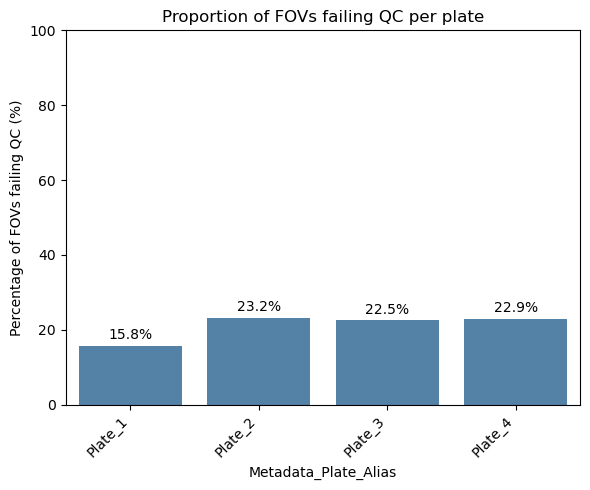

In [11]:
# Calculate percentage of rows that failed any QC check, grouped by plate
combined_df["Failed_Any"] = combined_df[
    ["Metadata_Blur_Flag", "Metadata_Saturation_Flag"]
].any(axis=1)
failed_percent_by_plate = (
    combined_df.groupby("Metadata_Plate_Alias")["Failed_Any"]
    .mean()
    .reset_index(name="Percent_Failed")
)
failed_percent_by_plate["Percent_Failed"] *= 100

# Create bar plot with a single color
plt.figure(figsize=(6, 5))
ax = sns.barplot(
    data=failed_percent_by_plate,
    x="Metadata_Plate_Alias",
    y="Percent_Failed",
    color="steelblue",
)

# Add percentage labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.text(
        x=p.get_x() + p.get_width() / 2,
        y=height + 1,  # slightly above the bar
        s=f"{height:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.ylabel("Percentage of FOVs failing QC (%)")
plt.title("Proportion of FOVs failing QC per plate")
plt.ylim(0, 100)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(output_directory / "qc_failure_rate_per_plate.png", dpi=500)
plt.show()

## Plot percentage failed FOV based on blur or saturation regardless of channel

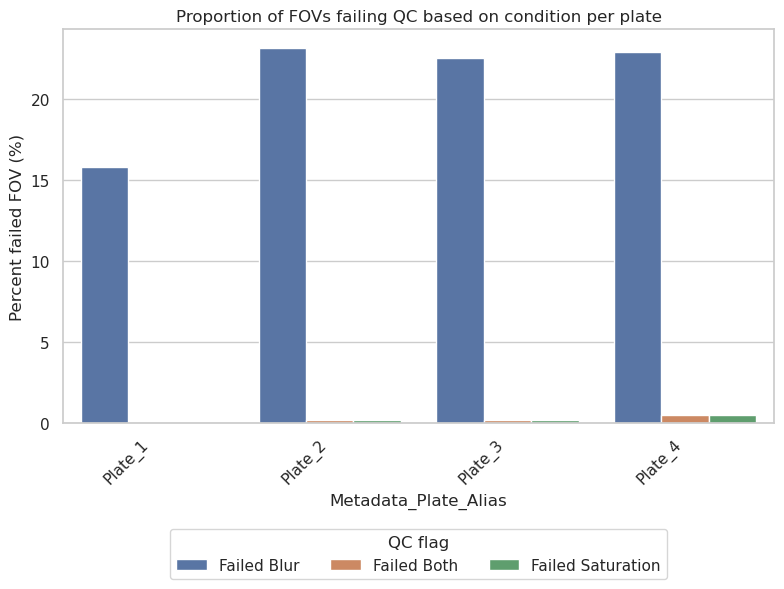

In [12]:
# Add a column for "failed both"
combined_df["Failed_Both"] = combined_df["Metadata_Saturation_Flag"].astype(
    bool
) & combined_df["Metadata_Blur_Flag"].astype(bool)

# Melt all three flag columns
flag_counts = combined_df.melt(
    id_vars="Metadata_Plate_Alias",
    value_vars=["Metadata_Saturation_Flag", "Metadata_Blur_Flag", "Failed_Both"],
    var_name="QC_Flag",
    value_name="Flagged",
)

# Convert to boolean if needed
flag_counts["Flagged"] = flag_counts["Flagged"].astype(bool)

# Clean up the legend labels
flag_counts["QC_Flag"] = flag_counts["QC_Flag"].map(
    {
        "Metadata_Saturation_Flag": "Failed Saturation",
        "Metadata_Blur_Flag": "Failed Blur",
        "Failed_Both": "Failed Both",
    }
)

# Count total per plate per flag type
total_counts = (
    flag_counts.groupby(["Metadata_Plate_Alias", "QC_Flag"])
    .size()
    .reset_index(name="Total")
)

# Count number of failed flags
fail_counts = (
    flag_counts[flag_counts["Flagged"]]
    .groupby(["Metadata_Plate_Alias", "QC_Flag"])
    .size()
    .reset_index(name="Failed")
)

# Merge and compute percentage
qc_summary = pd.merge(
    total_counts, fail_counts, on=["Metadata_Plate_Alias", "QC_Flag"], how="left"
).fillna(0)
qc_summary["Percent_Failed"] = (qc_summary["Failed"] / qc_summary["Total"]) * 100

# Plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(
    data=qc_summary, x="Metadata_Plate_Alias", y="Percent_Failed", hue="QC_Flag"
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Percent failed FOV (%)")
plt.title("Proportion of FOVs failing QC based on condition per plate")
plt.legend(
    title="QC flag",
    bbox_to_anchor=(0.5, -0.25),
    loc="upper center",
    ncol=3,  # number of columns for a horizontal layout
)
plt.tight_layout()
plt.subplots_adjust(bottom=0.28)  # reduce the whitespace belo
plt.savefig(output_directory / "qc_failure_rate_by_flag_type_per_plate.png", dpi=500)
plt.show()

## Create upset plot for all plates in combination with the breakdown of channels failing QC

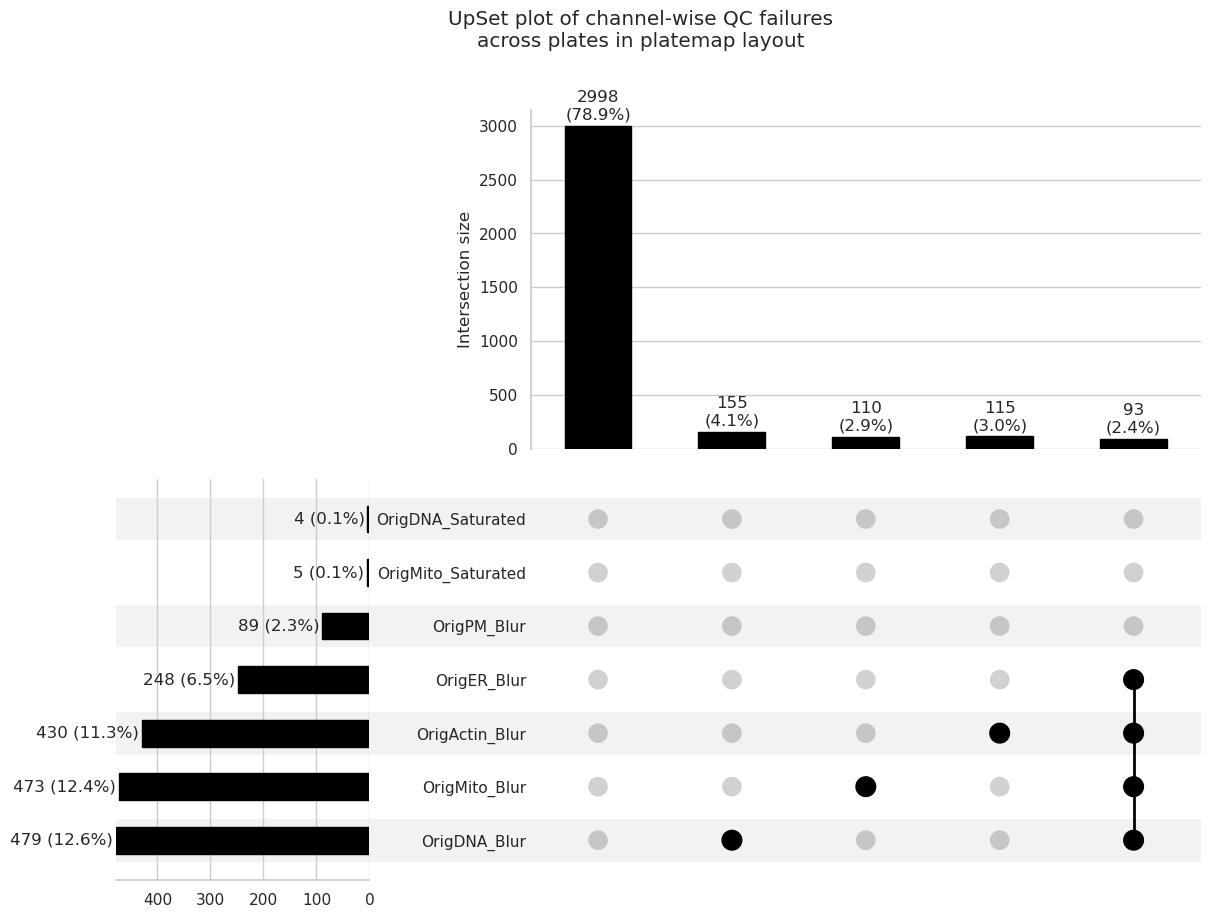

In [13]:
# Define the relevant QC columns
qc_columns = [
    "OrigActin_Saturated",
    "OrigDNA_Saturated",
    "OrigER_Saturated",
    "OrigMito_Saturated",
    "OrigPM_Saturated",
    "OrigActin_Blur",
    "OrigDNA_Blur",
    "OrigER_Blur",
    "OrigMito_Blur",
    "OrigPM_Blur",
]

# Make sure columns are boolean
qc_data = combined_df[qc_columns].astype(bool)

# Create the upset input
upset_data = from_indicators(qc_columns, qc_data)

# Create the figure with desired size
fig = plt.figure(figsize=(14, 10))  # Adjust the size as needed

# Plot the UpSet plot
plot(
    upset_data,
    fig=fig,
    element_size=None,
    show_counts=True,
    show_percentages=True,
    min_subset_size=75,
)
plt.suptitle("UpSet plot of channel-wise QC failures\nacross plates in platemap layout")
plt.savefig(
    output_directory / "upset_plot_channel_qc_failures.png",
    bbox_inches="tight",
    dpi=500,
)
plt.show()

## Generate heatmap to visualize which channels and conditions most impact the failing image sets

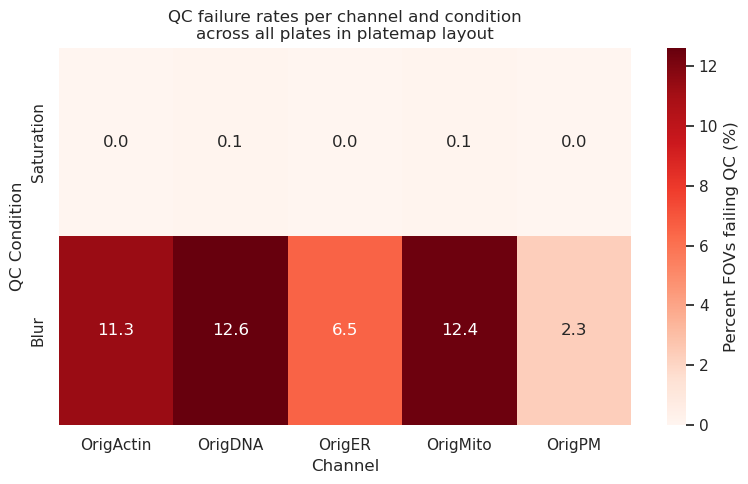

In [14]:
# Get boolean DataFrames for saturation and blur separately
sat_cols = [col for col in qc_columns if col.endswith("_Saturated")]
blur_cols = [col for col in qc_columns if col.endswith("_Blur")]

# Extract saturation and blur DataFrames
sat_df = qc_data[sat_cols]
blur_df = qc_data[blur_cols]

# Align columns so we can compare channels directly (remove suffixes for matching)
sat_df.columns = [col.replace("_Saturated", "") for col in sat_df.columns]
blur_df.columns = [col.replace("_Blur", "") for col in blur_df.columns]

# Calculate per-channel failure rates for each condition
sat_fail_rate = sat_df.mean() * 100
blur_fail_rate = blur_df.mean() * 100

# Combine into one DataFrame for plotting
heatmap_data = pd.DataFrame(
    {
        "Saturation": sat_fail_rate,
        "Blur": blur_fail_rate,
    }
)

plt.figure(figsize=(8, 5))
sns.heatmap(
    heatmap_data.T,
    annot=True,
    fmt=".1f",
    cmap="Reds",
    cbar_kws={"label": "Percent FOVs failing QC (%)"},
)
plt.title(
    "QC failure rates per channel and condition\nacross all plates in platemap layout"
)
plt.xlabel("Channel")
plt.ylabel("QC Condition")
plt.tight_layout()
plt.savefig(output_directory / "qc_failure_rates_heatmap.png", dpi=500)
plt.show()

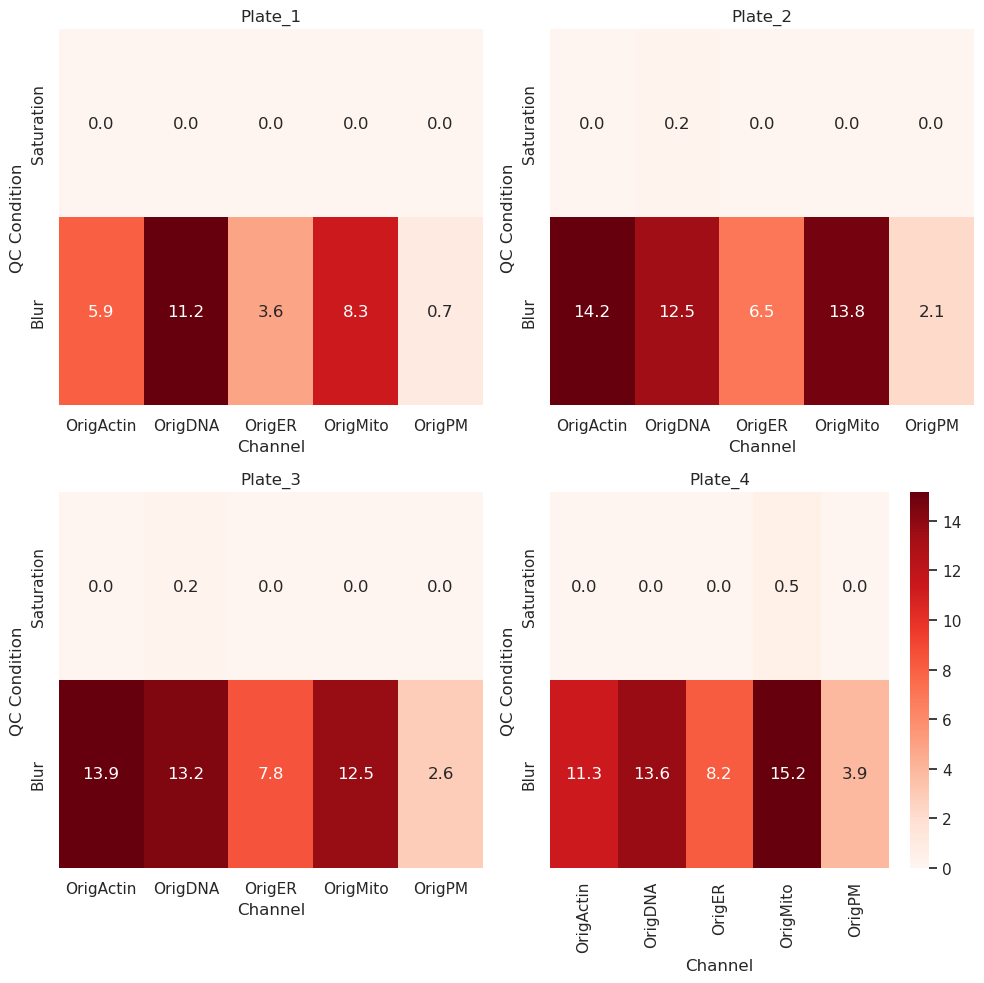

In [15]:
# Define QC columns
qc_columns = [
    "OrigActin_Saturated",
    "OrigDNA_Saturated",
    "OrigER_Saturated",
    "OrigMito_Saturated",
    "OrigPM_Saturated",
    "OrigActin_Blur",
    "OrigDNA_Blur",
    "OrigER_Blur",
    "OrigMito_Blur",
    "OrigPM_Blur",
]

# Keep Plate column and QC columns
qc_data = combined_df[["Metadata_Plate_Alias"] + qc_columns].copy()
qc_data[qc_columns] = qc_data[qc_columns].astype(bool)

# Get unique plates
plates = sorted(
    qc_data["Metadata_Plate_Alias"].unique(), key=lambda x: int(x.split("_")[-1])
)
n_plates = len(plates)

# Force 2x2 layout
rows, cols = 2, 2
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows), squeeze=False)

for i, plate in enumerate(plates):
    plate_df = qc_data[qc_data["Metadata_Plate_Alias"] == plate]

    # Separate saturation and blur
    sat_df = plate_df[[c for c in qc_columns if c.endswith("_Saturated")]].copy()
    blur_df = plate_df[[c for c in qc_columns if c.endswith("_Blur")]].copy()

    # Remove suffixes
    sat_df.columns = [c.replace("_Saturated", "") for c in sat_df.columns]
    blur_df.columns = [c.replace("_Blur", "") for c in blur_df.columns]

    # Compute failure rates per channel
    sat_fail_rate = sat_df.mean() * 100
    blur_fail_rate = blur_df.mean() * 100

    heatmap_data = pd.DataFrame({"Saturation": sat_fail_rate, "Blur": blur_fail_rate})

    r, c = divmod(i, cols)
    sns.heatmap(
        heatmap_data.T,
        annot=True,
        fmt=".1f",
        cmap="Reds",
        cbar=i == n_plates - 1,  # show colorbar only on last subplot
        ax=axes[r, c],
    )
    axes[r, c].set_title(f"{plate}")
    axes[r, c].set_xlabel("Channel")
    axes[r, c].set_ylabel("QC Condition")

# Hide any empty subplots
for j in range(i + 1, rows * cols):
    r, c = divmod(j, cols)
    axes[r, c].axis("off")

plt.tight_layout()
plt.savefig(output_directory / "qc_failure_rates_heatmap_by_plate.png", dpi=500)
plt.show()

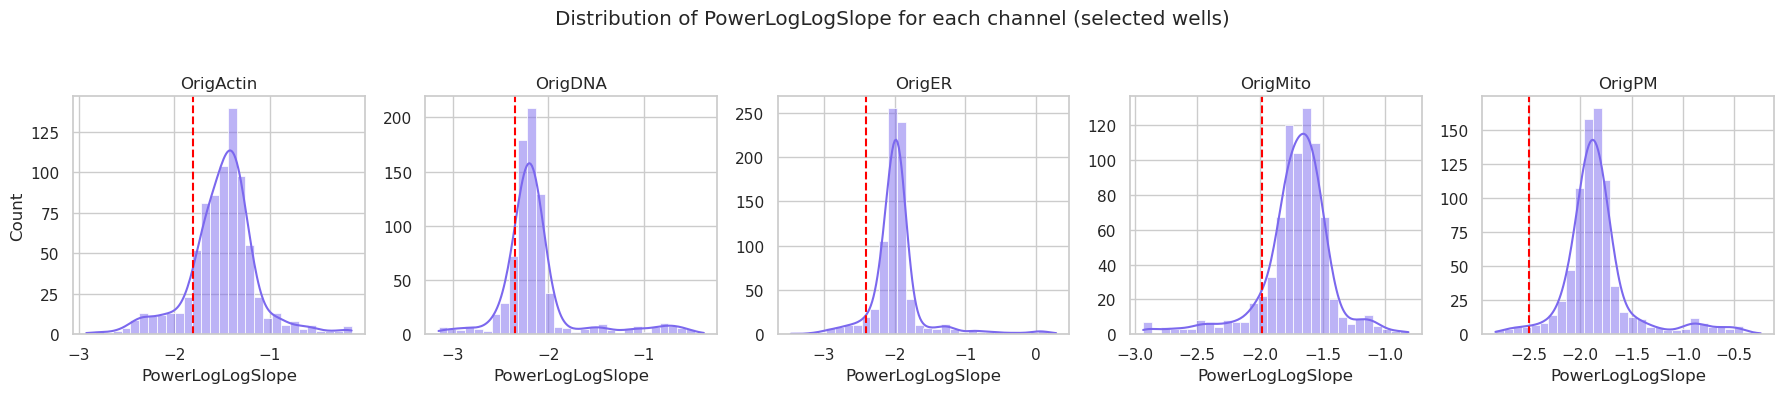

In [16]:
# Wells to include
selected_wells = ["B02", "B05", "B08", "B11", "E02", "E05", "E08", "E11"]

# Filter dataframe
filtered_df = combined_df[combined_df["Metadata_Well"].isin(selected_wells)]

# Plot distributions of PowerLogLogSlope per channel with blur thresholds
channels = ["OrigActin", "OrigDNA", "OrigER", "OrigMito", "OrigPM"]

plt.figure(figsize=(18, 4))
for i, channel in enumerate(channels, 1):
    plt.subplot(1, len(channels), i)
    sns.histplot(
        filtered_df[f"ImageQuality_PowerLogLogSlope_{channel}"],
        bins=30,
        kde=True,
        color="mediumslateblue",
    )
    plt.axvline(
        blur_thresholds[channel], color="red", linestyle="--", label="Blur threshold"
    )
    plt.xlabel("PowerLogLogSlope")
    plt.title(channel)
    if i == 1:
        plt.ylabel("Count")
    else:
        plt.ylabel("")
    plt.legend([], [], frameon=False)  # Remove legend

plt.suptitle("Distribution of PowerLogLogSlope for each channel (selected wells)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [17]:
# Find all FOVs that failed DNA blur QC
failed_dna_blur = combined_df[combined_df["OrigDNA_Blur"]]

# Sort by PowerLogLogSlope for OrigDNA (ascending: more negative = blurrier)
sorted_failed = failed_dna_blur.sort_values("ImageQuality_PowerLogLogSlope_OrigDNA")

# Get the middle index (or indices) for 3 examples
n = len(sorted_failed)
mid = n // 2
indices = [mid - 1, mid, mid + 1] if n >= 3 else list(range(n))

# Select the rows at those indices
middle_examples = sorted_failed.iloc[indices][
    [
        "Metadata_Plate",
        "Metadata_Well",
        "Metadata_Site",
        "ImageQuality_PowerLogLogSlope_OrigDNA",
    ]
]
middle_examples

,Metadata_Plate,Metadata_Well,Metadata_Site,ImageQuality_PowerLogLogSlope_OrigDNA
3425,CARD-CelIns-CX7_260113180001,D05,f00,-2.479633
3519,CARD-CelIns-CX7_260113180001,D08,f19,-2.479331
569,CARD-CelIns-CX7_260114180001,D04,f19,-2.475131


In [18]:
# Columns for saturation and blur flags
saturation_cols = [
    "OrigActin_Saturated",
    "OrigDNA_Saturated",
    "OrigER_Saturated",
    "OrigMito_Saturated",
    "OrigPM_Saturated",
]
blur_cols = [
    "OrigActin_Blur",
    "OrigDNA_Blur",
    "OrigER_Blur",
    "OrigMito_Blur",
    "OrigPM_Blur",
]

# Find rows that have OrigMito blur only (no other blur or saturation flags)
mito_blur_only_mask = (
    combined_df["OrigMito_Blur"]
    & ~combined_df[[c for c in blur_cols if c != "OrigMito_Blur"]].any(axis=1)
    & ~combined_df[saturation_cols].any(axis=1)
)

mito_blur_only = combined_df[mito_blur_only_mask].copy()

if mito_blur_only.empty:
    print("No rows with OrigMito blur only (no other blur or saturation flags).")
else:
    print(f"Found {len(mito_blur_only)} rows with OrigMito blur only.")
    # Sample up to 3 reproducibly
    sample_n = mito_blur_only.sample(n=min(3, len(mito_blur_only)))
    cols = [
        "Metadata_Plate",
        "Metadata_Well",
        "Metadata_Site",
        "ImageQuality_PowerLogLogSlope_OrigMito",
    ]
    display(sample_n[cols].reset_index(drop=True))

Found 110 rows with OrigMito blur only.


,Metadata_Plate,Metadata_Well,Metadata_Site,ImageQuality_PowerLogLogSlope_OrigMito
0,CARD-CelIns-CX7_260113180001,E06,f15,-2.042267
1,CARD-CelIns-CX7_260114100001,B04,f09,-2.084258
2,CARD-CelIns-CX7_260114100001,C07,f12,-2.014475


Search base set to: /media/18tbdrive/CFReT_screening_data/compound_screen/batch_3/platemap_11


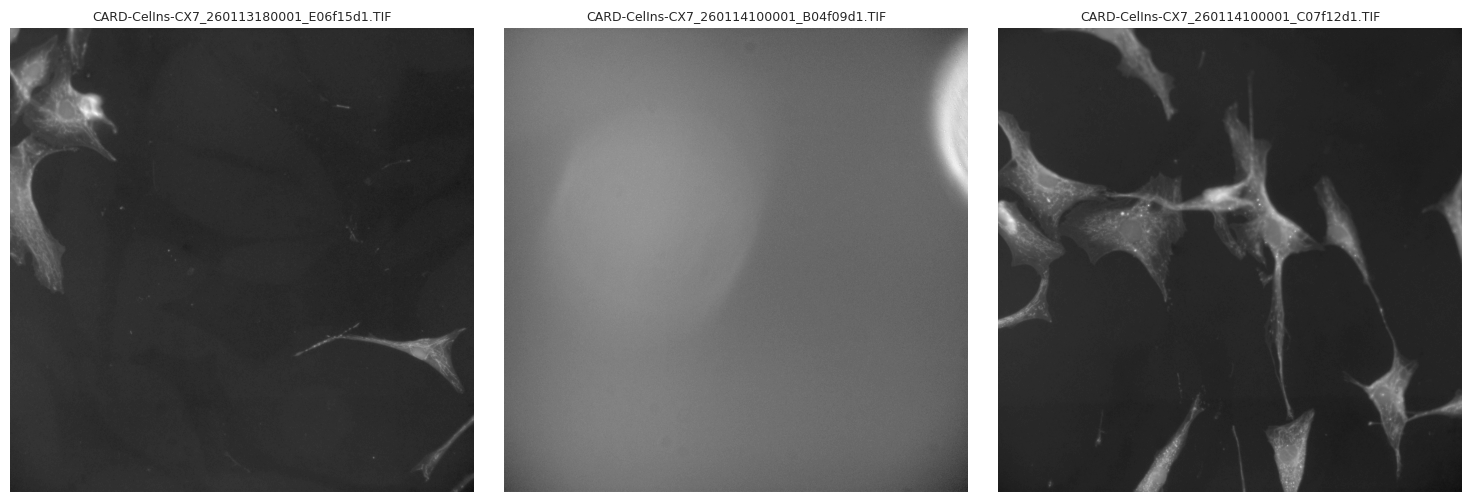

1: /media/18tbdrive/CFReT_screening_data/compound_screen/batch_3/platemap_11/11a/CARD-CelIns-CX7_260113180001/CARD-CelIns-CX7_260113180001_E06f15d1.TIF (Plate folder: card-celins-cx7_260113180001)
2: /media/18tbdrive/CFReT_screening_data/compound_screen/batch_3/platemap_11/11b/CARD-CelIns-CX7_260114100001/CARD-CelIns-CX7_260114100001_B04f09d1.TIF (Plate folder: card-celins-cx7_260114100001)
3: /media/18tbdrive/CFReT_screening_data/compound_screen/batch_3/platemap_11/11b/CARD-CelIns-CX7_260114100001/CARD-CelIns-CX7_260114100001_C07f12d1.TIF (Plate folder: card-celins-cx7_260114100001)


In [19]:
# Base directory and platemap
images_base_dir = pathlib.Path(
    "/media/18tbdrive/CFReT_screening_data/compound_screen"
).resolve(strict=True)

# Find the platemap folder no matter what intermediate folder is there
matches = list(images_base_dir.rglob(platemap_name))

if len(matches) == 0:
    raise FileNotFoundError(
        f"No folder named '{platemap_name}' found under {images_base_dir}"
    )
elif len(matches) > 1:
    print(f"Warning: multiple matches found for {platemap_name}, using the first one")

search_base = matches[0]
print(f"Search base set to: {search_base}")

exts = [".tif", ".tiff", ".png", ".jpg", ".jpeg", ".ome"]
keywords = ["d1", "mito", "origmito"]

# Prepare list of image paths for up to 3 sampled rows
rows = sample_n.reset_index(drop=True)
image_paths = []
plates_found = []

for idx in range(min(3, len(rows))):
    row = rows.loc[idx]
    img, plate_found = find_image_for_row_correct_plate(
        row, search_base, exts, keywords
    )
    image_paths.append(img)
    plates_found.append(plate_found)

# Display found images (brightened with gamma correction)
found = [p for p in image_paths if p is not None]
if not found:
    print("No matching Mito (d1) images found for the sampled rows.")
else:
    n = len(found)
    fig, axes = plt.subplots(1, n, figsize=(5 * n, 5))
    if n == 1:
        axes = [axes]
    for ax, p in zip(axes, found):
        try:
            img = plt.imread(p).astype(float)

            # Normalize 0-1 first
            img_norm = (img - img.min()) / max(img.max() - img.min(), 1e-8)

            # Apply gamma correction for brightening
            gamma = 0.5  # <1 brightens image, >1 darkens
            img_bright = np.power(img_norm, gamma)

            ax.imshow(img_bright, cmap="gray")
        except Exception:
            ax.text(0.5, 0.5, f"Failed to read\n{p.name}", ha="center")
        ax.set_title(p.name, fontsize=9)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Print which files and plate folders were used
for i, (p, pl) in enumerate(zip(image_paths, plates_found), 1):
    print(f"{i}: {p if p is not None else 'NOT FOUND'} (Plate folder: {pl})")

In [20]:
# --- Load all Image.csv ---
qc_root = pathlib.Path("qc_results")
all_csvs = list(qc_root.rglob("Image.csv"))
print(f"Found {len(all_csvs)} Image.csv files under {qc_root}")

loaded = []
prefixes = ["Metadata_"]

for csv_file in all_csvs:
    try:
        df = pd.read_csv(
            csv_file,
            usecols=lambda c: any(c.startswith(p) for p in prefixes)
            or c.startswith("ImageQuality_PowerLogLogSlope_")
            or c.startswith("ImageQuality_PercentMaximal"),
        )
    except Exception as e:
        print(f"Skipping {csv_file}: failed to read ({e})")
        continue

    plate_name = csv_file.parent.name
    df["Metadata_Plate"] = plate_name
    df["Platemap"] = str(csv_file.parent.parent.name)

    # Ensure flags are boolean
    for flag in ["Metadata_Blur_Flag", "Metadata_Saturation_Flag"]:
        if flag in df.columns:
            df[flag] = df[flag].astype(bool)

    loaded.append(df)

if not loaded:
    raise RuntimeError("No valid Image.csv files were loaded.")

combined_all = pd.concat(loaded, ignore_index=True)

# --- Create per-channel Saturation flags ---
percent_max_cols = [
    c for c in combined_all.columns if c.startswith("ImageQuality_PercentMaximal")
]
sat_mask = combined_all["Metadata_Saturation_Flag"].astype(bool)
for col in percent_max_cols:
    channel = col.replace("ImageQuality_PercentMaximal_", "")
    combined_all[f"{channel}_Saturated"] = sat_mask & (
        combined_all[col] > 0.10
    )  # We set 0.1 as threshold in CellProfiler

blur_mask = combined_all["Metadata_Blur_Flag"].astype(bool)
for col in combined_all.columns:
    if col.startswith("ImageQuality_PowerLogLogSlope_"):
        channel = col.replace("ImageQuality_PowerLogLogSlope_", "")
        if channel in blur_thresholds:
            combined_all[f"{channel}_Blur"] = blur_mask & (
                combined_all[col] < blur_thresholds[channel]
            )


# --- Aggregate per well per channel ---
def pivot_channel_flags(df, suffix):
    cols = [c for c in df.columns if c.endswith(suffix)]
    df_melt = df.melt(
        id_vars=["Metadata_Plate", "Platemap", "Metadata_Well"],
        value_vars=cols,
        var_name="Channel",
        value_name="Failed_FOVs",
    )
    df_melt["Channel"] = df_melt["Channel"].str.replace(suffix, "")
    agg = (
        df_melt.groupby(["Metadata_Plate", "Platemap", "Metadata_Well", "Channel"])
        .agg(Failed_FOVs=("Failed_FOVs", "sum"))
        .reset_index()
    )
    return (
        agg.pivot_table(
            index=["Metadata_Plate", "Platemap", "Metadata_Well"],
            columns="Channel",
            values="Failed_FOVs",
        )
        .add_prefix(f"Failed_{suffix.replace('_','')}_")
        .reset_index()
    )


sat_wide = pivot_channel_flags(combined_all, "_Saturated")
blur_wide = pivot_channel_flags(combined_all, "_Blur")

# --- Merge Saturation + Blur ---
well_level_df = pd.merge(
    sat_wide, blur_wide, on=["Metadata_Plate", "Platemap", "Metadata_Well"], how="outer"
).fillna(0)

# --- Total image sets per well ---
total_per_well = (
    combined_all.groupby(["Metadata_Plate", "Platemap", "Metadata_Well"])
    .size()
    .rename("Total_image_sets")
    .reset_index()
)
well_level_df = pd.merge(
    well_level_df,
    total_per_well,
    on=["Metadata_Plate", "Platemap", "Metadata_Well"],
    how="left",
)

# --- Overall failure per well ---
combined_all["Failed_Any"] = combined_all[
    ["Metadata_Blur_Flag", "Metadata_Saturation_Flag"]
].any(axis=1)
agg_total = (
    combined_all.groupby(["Metadata_Plate", "Platemap", "Metadata_Well"])
    .agg(
        Failed_Any=("Failed_Any", "sum"),
        Failed_Blur=("Metadata_Blur_Flag", "sum"),
        Failed_Saturation=("Metadata_Saturation_Flag", "sum"),
    )
    .reset_index()
)
well_level_df = pd.merge(
    well_level_df,
    agg_total,
    on=["Metadata_Plate", "Platemap", "Metadata_Well"],
    how="left",
)

# --- Compute percentages per channel/condition ---
for col in well_level_df.columns:
    if col.startswith("Failed_") and col not in [
        "Failed_Any",
        "Failed_Blur",
        "Failed_Saturation",
    ]:
        well_level_df[col.replace("Failed_", "Percent_Failed_")] = (
            well_level_df[col] / well_level_df["Total_image_sets"] * 100
        )

well_level_df["Percent_Failed_Any"] = (
    well_level_df["Failed_Any"] / well_level_df["Total_image_sets"] * 100
)
well_level_df["Percent_Failed_Blur"] = (
    well_level_df["Failed_Blur"] / well_level_df["Total_image_sets"] * 100
)
well_level_df["Percent_Failed_Saturation"] = (
    well_level_df["Failed_Saturation"] / well_level_df["Total_image_sets"] * 100
)

# --- Filter only DMSO control wells ---
control_wells = ["B02", "B05", "B08", "B11", "E02", "E05", "E08", "E11"]
well_level_df_controls = well_level_df[
    well_level_df["Metadata_Well"].isin(control_wells)
].copy()

# --- Keep only percentages and total image sets ---
percent_cols = [
    c for c in well_level_df_controls.columns if c.startswith("Percent_Failed_")
]
final_cols = [
    "Metadata_Plate",
    "Platemap",
    "Metadata_Well",
    "Total_image_sets",
] + percent_cols
well_level_df_controls_pct = well_level_df_controls[final_cols].copy()

# --- Result ---
print(well_level_df_controls_pct.to_string(index=False))

# --- Save to CSV ---
output_path = pathlib.Path("well_level_image_qc_controls_summary.csv")
well_level_df_controls_pct.to_csv(output_path, index=False)
print(f"Saved well-level percentage summary to {output_path}")

Found 44 Image.csv files under qc_results
              Metadata_Plate    Platemap Metadata_Well  Total_image_sets  Percent_Failed_Saturated_OrigActin  Percent_Failed_Saturated_OrigDNA  Percent_Failed_Saturated_OrigER  Percent_Failed_Saturated_OrigMito  Percent_Failed_Saturated_OrigPM  Percent_Failed_Blur_OrigActin  Percent_Failed_Blur_OrigDNA  Percent_Failed_Blur_OrigER  Percent_Failed_Blur_OrigMito  Percent_Failed_Blur_OrigPM  Percent_Failed_Any  Percent_Failed_Blur  Percent_Failed_Saturation
CARD-CelIns-CX7_251023210001  platemap_1           B02                25                                 0.0                               8.0                              0.0                                0.0                              0.0                            4.0                          0.0                         0.0                           4.0                         0.0                 8.0                  4.0                        8.0
CARD-CelIns-CX7_251023210001  platemap_1  

In [21]:
# --- Aggregate well-level controls to plate + platemap level ---
agg_cols = [c for c in well_level_df_controls_pct.columns if c.startswith("Failed_")]
percent_cols = [
    c for c in well_level_df_controls_pct.columns if c.startswith("Percent_Failed_")
]

# Build a mapping of column -> aggregation function and pass it as a single dict to .agg
agg_map = {col: "sum" if col in agg_cols else "mean" for col in agg_cols + percent_cols}

plate_agg = (
    well_level_df_controls_pct.groupby(["Metadata_Plate", "Platemap"])
    .agg(agg_map)
    .reset_index()
)

# Optionally compute total FOVs for the plate
plate_agg["Total_image_sets"] = (
    well_level_df_controls_pct.groupby(["Metadata_Plate", "Platemap"])[
        "Total_image_sets"
    ]
    .sum()
    .values
)

# Show aggregated plate-level table
print(plate_agg.to_string(index=False))

# Save to CSV
plate_agg.to_csv("plate_level_image_qc_controls_summary.csv", index=False)
print("Saved plate-level control data to 'plate_level_image_qc_controls_summary.csv'")

              Metadata_Plate    Platemap  Percent_Failed_Saturated_OrigActin  Percent_Failed_Saturated_OrigDNA  Percent_Failed_Saturated_OrigER  Percent_Failed_Saturated_OrigMito  Percent_Failed_Saturated_OrigPM  Percent_Failed_Blur_OrigActin  Percent_Failed_Blur_OrigDNA  Percent_Failed_Blur_OrigER  Percent_Failed_Blur_OrigMito  Percent_Failed_Blur_OrigPM  Percent_Failed_Any  Percent_Failed_Blur  Percent_Failed_Saturation  Total_image_sets
CARD-CelIns-CX7_251023210001  platemap_1                                 0.0                               1.0                              0.0                                0.0                              0.0                            0.5                          2.5                         0.5                           2.5                         0.0                 4.5                  4.0                        1.0               200
CARD-CelIns-CX7_251124150001  platemap_1                                 0.0                               1.0  